In [ ]:
#| default_exp bridge_widget

In [ ]:
#| export
from __future__ import annotations

# Bridge widget helpers
> Basis of the bridge: bundling, blocking operations, and AnyWidget.

This module provides low-level infrastructure for Bridget:
- **JS Bundling**: Concatenate and transform JavaScript sources
- **Blocking Operations**: Block Python execution while allowing UI interaction
- **AnyWidget Base**: `BridgeWidget` class for bidirectional messaging

<!-- # Prologue -->

In [ ]:
#| export
import os
import shutil
import time
from contextlib import contextmanager
from functools import cached_property
from pathlib import Path
from typing import Any
from typing import Callable
from typing import overload
from typing import Protocol
from typing import Self
from urllib.parse import ParseResult
from urllib.parse import urlparse

import anyio
import anywidget
import fastcore.all as FC
import ipywidgets as W
import nbdev.config
import traitlets as T
from fastcore.xml import FT
from fastcore.xml import NotStr
from fasthtml.basics import ft_html
from jupyter_ui_poll import ui_events
from pote.basic import bundle_path
from pote.basic import Empty
from pote.basic import empty


In [ ]:
#| hide
os.environ['DEBUG_BRIDGET'] = 'True'

In [ ]:
#| export
from bridget.helpers import bridge_cfg
from bridget.helpers import DEBUG
from bridget.helpers import id_gen
from bridget.helpers import kounter
from bridget.helpers import run_command
from bridget.js_transform import JSImportTransform


In [ ]:
#| hide
import itertools
import tempfile
from typing import cast

from anyio import from_thread
from fastcore.test import *
from fastcore.xml import to_xml
from fasthtml.common import show
from fasthtml.xtend import Script
from IPython.display import DisplayHandle
from ipywidgets.widgets.widget import CallbackDispatcher
from pote.common import setup_console
from pote.test import test_raises
from pote.widget import cleanupwidgets


In [ ]:
#| hide
import bridget
from bridget.helpers import arun_command
from bridget.helpers import DetailsJSON
from bridget.helpers import HTML
from bridget.helpers import ms2str
from bridget.helpers import ts


In [ ]:
#| hide
console, cprint = setup_console(140)

In [ ]:
#| exporti

new_id = id_gen()
BUNDLE_PATH = bundle_path(__name__)
bridge_cfg.for_module(__name__)

{'auto_show': False, 'auto_mount': False, 'auto_id': False, 'bundle_cfg': {'out_dir': [Path('/Users/vic/dev/repo/project/bridget/nbs/js'), Path('/Users/vic/dev/repo/project/bridget/nbs'), Path('/Users/vic/dev/repo/project/bridget/bridget/js'), Path('/Users/vic/dev/repo/project/bridget/bridget')], 'rewrite_imports': True, 'import_name': 'brdimport'}, 'bootstrap': False, 'current_did': None}

In [ ]:
#| exporti

_n = '\n'

In [ ]:
#| hide
(bundle_path('bridget')/'js').mkdir(exist_ok=True)
W.Widget.close_all()  # we don't want stale widgets around when developing

# VFile System

Hacking around to get anywidget `vfile:` working in Script and Style. 
Unfortunately, it's not a public API. If useful, we could write a similar util for Bridget.

NOTE: `%load_ext anywidget` must have been previously run for this to work

In [ ]:
#| export

def read_vfile(cts:str)->str|None:
    # %load_ext anywidget should have been previously run for this to work
    import anywidget
    from anywidget._file_contents import _VIRTUAL_FILES
    if isinstance(cts, str) and cts.startswith('vfile:'):
        if fn := _VIRTUAL_FILES.get(cts, None):
            return fn.contents

## vfile: Components

> **FastHTML** xtend `Script` and `Style` with `vfile:` support.

In [ ]:
#| export

@FC.delegates(ft_html, keep=True)  # type: ignore
def ScriptV(code:str="", **kwargs)-> FT:
    "A Script w/ code or `vfile:` contents that doesn't escape its code"
    return ft_html('script', (_n, NotStr(FC.ifnone(read_vfile(code), code))), **kwargs)

@FC.delegates(ft_html, keep=True)  # type: ignore
def StyleV(*c, **kwargs)-> FT:
    "A Style w/ code or `vfile:` contents that doesn't escape its code"
    return ft_html('style', tuple(NotStr(FC.ifnone(read_vfile(_), _)) for _ in c), **kwargs)


## anysource

In [ ]:
#| export

class SourceProvider(Protocol):
    "Object with a .source attribute (string or callable returning string)"
    @property
    def source(self) -> str | cached_property[str]: ...

def _source(o: str|Path|SourceProvider) -> str:
    if hasattr(o, 'source'): return o.source  # type: ignore
    return FC.ifnone(read_vfile(o), o if isinstance(o, str) else o.read_text())  # type: ignore

def anysource(*args: str|Path|SourceProvider):
    "Read and join text from files, vfiles or strings"
    return '\n'.join(filter(None, (_source(_) for _ in args)))

In [ ]:
class Src:
    source = 'c'
test_eq(anysource('a', '', 'b', Src()), 'a\nb\nc')

# Bundling utilities
> Very basic JS bundler. Only concat and basic import transformation for now.

Two variants: async for use with `await`, sync for direct calls.  
The sync version uses `from_thread` to handle async operations.

In [ ]:
async def bundled(*sources, debugger=False, command:str|None=None, **kwargs):
    "Concat javascript `sources`. Optionally, first run command."
    if command:
        try:
            _, stderr = await arun_command(command, **kwargs)
        except Exception as e:
            stderr = str(e)
        if stderr: raise RuntimeError(stderr)
    if debugger: return anysource('debugger;', *sources)
    return anysource(*sources)

In [ ]:
test_eq(await bundled('a'), 'a')
with test_raises(FileNotFoundError):
    await bundled(Path('not_found.js'))
with test_raises(RuntimeError):
    await bundled(command='ls', cwd=Path('/not/found'))
test_eq(await bundled(command='ls', debugger=True), 'debugger;')

In [ ]:
with tempfile.NamedTemporaryFile('w') as fp:
    fp.write('a')
    fp.seek(0)
    test_eq(await bundled(Path(fp.name)), 'a')

In [ ]:
def bundled(*sources, debugger=False, command:str|None=None, **kwargs):
    "Concat javascript `sources`. Run `command` first if not None."
    async def _run(): return await arun_command(command, **kwargs)  # type: ignore
    if command:
        with from_thread.start_blocking_portal() as portal: 
            try: _, stderr = portal.call(_run)
            except Exception as e: stderr = str(e)
            if stderr: raise RuntimeError(stderr)
    if debugger: return anysource('debugger;', *sources)
    return anysource(*sources)

In [ ]:
test_eq(bundled('a'), 'a')
with test_raises(FileNotFoundError):
    bundled(Path('not_found.js'))
with test_raises(RuntimeError):
    bundled(command='ls', cwd=Path('/not/found'))
test_eq(bundled(command='ls', debugger=True), 'debugger;')

In [ ]:
with tempfile.NamedTemporaryFile('w') as fp:
    fp.write('a')
    fp.seek(0)
    test_eq(bundled(Path(fp.name)), 'a')

In [ ]:
#  ./node_modules/.bin/esbuild --bundle --format=esm --outdir=bridget/js nbs/js/logger.js 

In [ ]:
#| export

class Bundle:
    "Basic JS bundler class."
    def __init__(self, 
        *sources: str|Path,         # javascript source
        bundle:bool=True,           # Bundle using `bundler` with sources as entry points
        bundler:str='copy',         # Bundler type to use, one of 'esbuild', 'copy'
        outdir:str|Path|None=None,  # Output directory for bundled files
        command:str|None=None,      # Run `command` first if not None
        **cmd_kw                    # Command kwargs
    ):
        self.sources, self.bundle, self.bundler = list(sources), bundle, bundler
        self.command, self.cmd_kwargs = command, cmd_kw
        self.outdir = Path(outdir).resolve() if outdir else self.default_outdir()
    @classmethod
    def default_outdir(cls): return nbdev.config.get_config().lib_path/'js'
    @classmethod
    def transform(cls, src:str):
        if bridge_cfg.bundle_cfg.rewrite_imports: src = JSImportTransform(bridge_cfg.bundle_cfg.import_name)(src)
        return src
    def __str__(self): return self.source
    def __call__(self, 
        *args:str|Bundle,  # Insert sources before the bundle
        debugger=False,    # Insert `debugger` at the beginning of the bundle
        ts=False,          # Insert timestamp at the beginning of the bundle
        transform=True,    # Transform resulting source if `bundler` is `copy` and `rewrite_imports` is True
        **kwargs):
        "Concatenate sources. This is the only point where the source is transformed"
        srcs = [_.source if isinstance(_, Bundle) else _ for _ in args]
        src = anysource(f"debugger;{('  // '+str(time.time())) if ts else ''}" if debugger else '', *srcs, self.source)
        return self.transform(src) if transform and self.bundler == 'copy' else src
    @cached_property
    def bundled_sources(self) -> list[str|Path]:
        "Bundle the sources using `esbuild` or `copy`. Return sources and paths to the bundled files."
        if self.command: _ = run_command(self.command, **self.cmd_kwargs)
        if not self.bundle: return self.sources
        outdir = self.outdir
        if self.bundler == 'copy':
            srcs = [shutil.copy(_, outdir) if _.resolve().parent != outdir else _ for _ in self.sources if isinstance(_, Path)]
        else:  # esbuild
            if srcs := ' '.join([_.resolve().as_posix() for _ in self.sources if isinstance(_, Path)]):
                cmd = f"./node_modules/.bin/esbuild --bundle --format=esm --outdir={outdir} {srcs}"
                try: _ = run_command(cmd, cwd=nbdev.config.get_config().config_path)
                except Exception as e: raise ValueError(f"Error bundling sources: {e}")
        return [(outdir / _.name if isinstance(_, Path) else _) for _ in self.sources]
    def bundle_path_of(self, source: str|Path): return self.outdir / Path(source).name
    @cached_property
    def source(self): return anysource(*self.bundled_sources)
    def join(self, *sources: str|Path):
        return type(self)(*self.sources, *sources, bundle=self.bundle, outdir=self.outdir, 
            bundler=self.bundler, command=self.command, **self.cmd_kwargs)


@FC.delegates(Bundle.__init__, keep=True)  # type: ignore
def bundled(*sources: str|Path, **kwargs):
    return Bundle(*sources, **kwargs)

In [ ]:
(f1 := Path('./js/b.js')).write_text('B');

In [ ]:
bnd1 = bundled('a', f1, 'c')
test_eq(bnd1.sources, ('a', f1, 'c'))
test_eq(bnd1.bundled_sources, ('a', bnd1.outdir/ f1.name, 'c'))
test_eq(bnd1.source, 'a\nB\nc')
test_eq(bnd1(), 'a\nB\nc')
f2 = Path(bnd1.bundled_sources[1])

src = 'js/test.js'
bnd2 = bundled(Path(src))
test_eq(bnd2.bundled_sources[0], bundle_path('bridget')/src)
test_eq(bnd2.bundled_sources[0].read_text(), Path(src).read_text())  # type: ignore
f3 = Path(bnd2.bundled_sources[0])
test_eq(bnd2.bundle_path_of(src), f3)

prj_root = Path().resolve().parent
Path(src).resolve().relative_to(prj_root), f3.relative_to(prj_root)

(Path('nbs/js/test.js'), Path('bridget/js/test.js'))

`Bundle`(...), or `bundled`(...), works lazily, it simply create the bundle instance. It won't move, transform, or aggregate files until you explicitly call it (or retrieve `source` or `bundled_sources`):

`bundled(..., bundle=True,bundler='copy').bundled_sources`, the default, will just copy the sources to the outdir

In [ ]:
with tempfile.NamedTemporaryFile('w', suffix='.js', dir='./js') as fp:
    (p := Path(fp.name)).write_text('asdfgh')
    bndl = bundled(p, bundler='esbuild')
    test_is('asdfgh' in bndl(), True)
    bndl.bundled_sources[0].unlink()  # type: ignore

bnd3 = bundled(f1, Path(src), bundler='esbuild')
test_eq(bnd3.bundled_sources, (bnd3.outdir/ f1.name, bundle_path('bridget')/src))
test_is(r'stripAnsi("\x1B[4mBridget\x1B[0m")' in bnd3(), True)
f3 = Path(bnd3.bundled_sources[1])

Path(src).resolve().relative_to(prj_root), f3.relative_to(prj_root)

(Path('nbs/js/test.js'), Path('bridget/js/test.js'))

`bundled(..., bundle=True,bundler='esbuild').bundled_sources` will bundle each Path in `sources` as entry point.

In [ ]:
with test_raises(ValueError):
    bundled(Path('not_found.js'), bundler='esbuild')()
with test_raises(FileNotFoundError):
    bundled(bundler='esbuild', command='ls', cwd=Path('/not/found'))()

In [ ]:
bnd4 = bundled('import {a,b,c} from "./js/d.js"')
test_eq(bnd4.source, 'import {a,b,c} from "./js/d.js"')

test_eq(bnd4(), 'const {a, b, c} = await brdimport("./js/d.js");')

Note that `source` and `__call__` are not the same.

`source` will simply concatenate all the bundled sources.

`__call__` can bundled additional sources (string or another `Bundle`) and will tranform the final source. This is what you should use as the `_esm` of  AnyWidgets.

In [ ]:
test_eq(bundled(command='ls')(debugger=True), 'debugger;')

src = bundled()(debugger=True, ts=True)
print(src)
test_is('debugger;  // ' in src, True)

src = bundled('import a from "b"')(debugger=True)
test_eq(src, 'debugger;\nconst {default: a} = await brdimport("b");')
print(src)

src = bnd3('// a;', debugger=True)
cprint(src)

debugger;  // 1764771018.388513
debugger;
const {default: a} = await brdimport("b");


debugger;
// a;
// nbs/js/b.js
B;

// nbs/js/test.js
debugger;
var stripAnsi = require_strip_ansi();
function test() {
  console.log("test() called");
  console.log(stripAnsi("\x1B[4mBridget\x1B[0m"));
}
var test_default = test;
export {
  test_default as default
};

In [ ]:
for f in (f1, f2, f3): f.unlink(True)

> Resolve a JavaScript module specifier relative to a base path.

Given a string containing a module specifier like the ones used in JS `import` declarations or `dynamic import()`, returns an absolute URL or a local `Path` to an existing file.

[the HTML spec](https://html.spec.whatwg.org/multipage/webappapis.html#resolve-a-module-specifier)  
[MDN](https://developer.mozilla.org/en-US/docs/Web/JavaScript/Reference/Statements/import#module_specifier_resolution)


In [ ]:
show(DetailsJSON(bridge_cfg.as_dict(), summary='Bridget Config'))

In [ ]:
#| output: false

cprint(bridge_cfg.bundle_cfg.out_dir)

[
    Path('/Users/vic/dev/repo/project/bridget/nbs/js'),
    Path('/Users/vic/dev/repo/project/bridget/nbs'),
    Path('/Users/vic/dev/repo/project/bridget/bridget/js'),
    Path('/Users/vic/dev/repo/project/bridget/bridget')
]

In [ ]:
#| output: false

if BUNDLE_PATH.resolve() not in (cfg := bridge_cfg.bundle_cfg).out_dir:
    cfg.update(out_dir=[BUNDLE_PATH, *cfg.out_dir])
cprint(bridge_cfg.bundle_cfg.out_dir)

[
    Path('/Users/vic/dev/repo/project/bridget/nbs/js'),
    Path('/Users/vic/dev/repo/project/bridget/nbs'),
    Path('/Users/vic/dev/repo/project/bridget/bridget/js'),
    Path('/Users/vic/dev/repo/project/bridget/bridget')
]

By default, Bridget looks for JS files in:
- the python bundle, if it can be determined (use `bridge_cfg.for_module(...)`)
- `nbdev.config.get_config().lib_path` / 'js' and `nbdev.config.get_config().lib_path` / 'js', if found
- `Path.cwd()` and `Path.cwd()`/'js' at time of call

More locations can be added by modifying the `out_dir` of the `bundle_cfg` object.

In [ ]:
#| export

_valid_schemes = {
    'http', 'https', # Web resources
    'data',          # Data URLs
    'file',          # File URLs
    'node',          # Node.js built-ins
    'ftp', 'ftps',   # FTP resources
    'blob',          # Blob URLs (browser)
}

def _resolve_local(spec, bases) -> Path | None:
    "Resolve a local file path relative to `bases` list of dirs."
    spec = spec[spec.startswith('/'):]
    for base in bases:
        if (resolved := base / spec).exists(): return resolved

def resolve_ESM(spec: str, base:str|Path|None=None) -> Path | ParseResult | None:
    "Resolve a JavaScript module specifier relative to `base` or `bundle_cfg.out_dir`."
    bases = [Path(base)] if base else [*bridge_cfg.bundle_cfg.out_dir, Path.cwd(), Path.cwd()/'js']
    if spec.startswith(('/', './', '../')): return _resolve_local(spec, bases)  # Relative specifier
    parsed = urlparse(spec)
    if (scheme := parsed.scheme) in _valid_schemes:
        if scheme != 'file': return parsed
        return _resolve_local(parsed.path, bases)

In [ ]:
test_eq(resolve_ESM('./non-existent.js'), None)
test_eq(resolve_ESM('/non-existent.js'), None)
test_eq(resolve_ESM('./bridge.js'), Path('./js/bridge.js').resolve())

Test relative specifiers (these will depend on actual files existing)


In [ ]:
test_eq(resolve_ESM('asdfretgs'), None)
test_eq(resolve_ESM('asdfretgs:wrwteryeyt'), None)

result = cast(ParseResult, resolve_ESM('https://unpkg.com/htmx.org@next/dist/htmx.js'))
test_eq(result.scheme, 'https')
test_eq(result.netloc, 'unpkg.com')

result = cast(ParseResult, resolve_ESM('data:text/javascript,export default 42;'))
test_eq(result.scheme, 'data')

test_eq(resolve_ESM('file:///path/to/x.js'), None)
test_eq(resolve_ESM('FILE:///observer.js', Path('./js')), Path('js/observer.js'))

In [ ]:
# result = resolve_ESM('data:application/json,{"foo":42}', { type="json" })
# test_eq(result.scheme, 'data')

Absolute specifiers (URLs)

In [ ]:
test_eq(resolve_ESM('lodash'), None)
test_eq(resolve_ESM('observer.js', Path('./js')), None)

Test bare specifiers (TBD, not yet supported)

Look up for JS files in well-known locations and return the contents

In [ ]:
#| export

def get_ESM(module_spec):
    "Contents of a JS module"
    mod = resolve_ESM(module_spec)
    if isinstance(mod, Path): return Bundle.transform(mod.read_text())
    if isinstance(mod, ParseResult): return mod.geturl()

In [ ]:
test_eq(get_ESM('lodash'), None)
test_eq(get_ESM('./test.js'), Path('./js/test.js').read_text())
test_eq(get_ESM('https://a'), 'https://a')

In [ ]:
with tempfile.NamedTemporaryFile('w', dir='./js') as fp:
    p = Path(fp.name)
    p.write_text('import {a} from "b"')
    n = f"/{p.relative_to(Path('./js').resolve())}"
    test_eq(get_ESM(n), 'const {a} = await brdimport("b");')

# BlockingWidget

## JS -> Python

In [ ]:
class Cons(anywidget.AnyWidget):
    _esm = '''
export default {
  async initialize({ model, experimental }) {
    model.on("msg:custom", async (cmd) => {
      const { kind, msg, timeout } = cmd;
      if (kind === 'brd-command') {
        let [res, buffers] = await experimental.invoke("_upper", msg, {signal: AbortSignal.timeout(timeout)});
        console.log(res);
      } else console.log(cmd);
    }); 
  },
};
'''
    @anywidget.experimental.command  # type: ignore
    def _upper(self, msg, buffers):
        # print(f'{msg=} {buffers=}')
        return msg.upper(), buffers
    
    def to_console(self, msg):
        self.send({'kind': 'brd-command', 'msg': msg, 'timeout': 5e3})

In [ ]:
from bridget.helpers import find_active_widgets, get_kernel_widgets_comms, get_active_widgets_comms

In [ ]:
ww = find_active_widgets()
ww

[]

In [ ]:
w = Cons()

In [ ]:
w.to_console('Hello, worlds!')

The (still) experimental `invoke` feature of `AnyWidget` allows for blocking operations frontend-backend.  
We'll also need the other way around, but that's is surprisingly more involved.

## Python -> JS

In [ ]:
%matplotlib inline

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

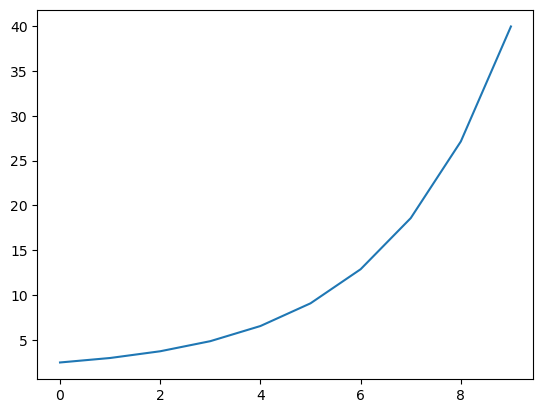

In [ ]:

base = 1.5
fig = plt.figure()#figsize=(4, 2.67))
plt.plot(base + base**np.arange(10));

In [ ]:
#| export

def exp_backoff(base:float=1.552, max_value:float=10.0):
    "Exponential backoff generator of values until cumulative value is max_value, then yields 0 and stops."
    if base <= 0: yield 0; return
    i, cum_sum, prev_t = 1, 0, 0
    while cum_sum < max_value:
        t = max(base**i, prev_t) if base > 1 else base*i
        t = min(t, max_value - cum_sum)
        yield t
        cum_sum += t
        prev_t = t
        i += 1
    yield 0

In [ ]:
list(itertools.takewhile(lambda t: t, exp_backoff()))

[1.552, 2.408704, 3.7383086080000005, 2.3009873919999997]

In [ ]:
list(itertools.takewhile(lambda t: t, exp_backoff(max_value=60)))

[1.552,
 2.408704,
 3.7383086080000005,
 5.8018549596160005,
 9.004478897324033,
 13.9749512486469,
 21.68912433789999,
 1.8305779485130742]

In [ ]:
list(itertools.takewhile(lambda t:t, exp_backoff(0.4, 3)))

[0.4, 0.8, 1.2000000000000002, 0.5999999999999996]

In [ ]:
list(itertools.takewhile(lambda t:t, exp_backoff(1*0.0776, 1)))

[0.0776, 0.1552, 0.2328, 0.3104, 0.22399999999999998]

In [ ]:
boff = iter(exp_backoff())
t, sum = 1, 0
while t:
    sum += (t := next(boff))
    print(f"t: {t:0.4f} sum: {sum:0.4f}")

t: 1.5520 sum: 1.5520
t: 2.4087 sum: 3.9607
t: 3.7383 sum: 7.6990
t: 2.3010 sum: 10.0000
t: 0.0000 sum: 10.0000


In [ ]:
tm = 5.0
boff = iter(exp_backoff(tm*0.1, tm))
t, sum = 1, 0
while t:
    sum += (t := next(boff))
    print(f"t: {t:0.4f} sum: {sum:0.4f}")

t: 0.5000 sum: 0.5000
t: 1.0000 sum: 1.5000
t: 1.5000 sum: 3.0000
t: 2.0000 sum: 5.0000
t: 0.0000 sum: 5.0000


In [ ]:
#| exporti

_xx = ['-_-', 'o_o']
def _show(finish: bool=False):
    if finish: print('._.')
    else: print(_xx[0], end="\r", flush=True); _xx[:] = _xx[::-1]

In [ ]:
class BlockingMixin(W.Widget):
    "A mixin for widgets that supports blocking custom messages with the front-end."
    _cbs: CallbackDispatcher

    def on_msg(self, cb, remove=False):
        if not hasattr(self, '_cbs'): self._cbs = CallbackDispatcher()
        self._cbs.register_callback(cb, remove=remove)
        super().on_msg(cb, remove=remove)

    def send(self, msg, timeout: float|None=None, buffers=None, 
            sleep: float = 1/15, n: int = 10, show: Callable[[bool], None]|None = None
    ) -> tuple[Any|Empty, Any|Empty]|None:
        "Send `msg` to the front-end. If `timeout` seconds is not None, calling blocks."
        if timeout is None: 
            for cb in self._cbs.callbacks: super().on_msg(cb)
            return super().send(msg, buffers)
        for cb in self._cbs.callbacks: super().on_msg(cb, remove=True)
        res = self._send_msg(msg, buffers,timeout, sleep, n, show)
        # NOTE: restoring normal callbacks now implies that front-end can yet send back a result
        # even if python timeout was triggered.
        for cb in self._cbs.callbacks: super().on_msg(cb)
        return res
    
    async def asend(self, msg, timeout: float=5.0, buffers=None, 
            sleep: float = 1/15, n: int = 10, show: Callable[[bool], None]|None = None
    ) -> tuple[Any|Empty, Any|Empty]|None:
        "Send `msg` to the front-end. Call will end after `timeout` seconds if `timeout` is not None."
        for cb in self._cbs.callbacks: super().on_msg(cb, remove=True)
        res = await self._asend_msg(msg, buffers, timeout, sleep, n, show)
        for cb in self._cbs.callbacks: super().on_msg(cb)
        return res

    def _send_msg(self, msg, buffers=None, timeout: float = 5.0, 
            sleep: float = 1/15, n: int = 10, show: Callable[[bool], None]|None = None
    ) -> tuple[Any|Empty, Any|Empty]:
        "Send blocking `msg` to the front-end. Return response tuple (content, buffers), or (empty, empty) if `timeout`."
        boff = iter(exp_backoff(timeout*0.776, timeout))
        timeout, start_time = next(boff), time.time()
        result = None
        def _on_msg(_, msg, buffers):
            nonlocal result
            if result is None: result = (msg, buffers)
        super().on_msg(_on_msg)  # register transient callback
        try:
            super().send(msg, buffers)
            with ui_events() as ui_poll:
                while True:
                    if sleep: time.sleep(sleep)
                    ui_poll(n)
                    if (time.time() - start_time) > timeout:
                        timeout, start_time = next(boff), time.time()
                        if not timeout: result = (empty, empty)
                    if result is not None:
                        content, buffers = result
                        if content is empty: return (empty, empty)
                        self._cbs(self, content, buffers)
                        return content, buffers
                    if show: show(False)
        except Exception as e:
            if isinstance(e, RuntimeError): raise
            raise RuntimeError(f"Error during message processing: {str(e)}") from e
        finally:
            super().on_msg(_on_msg, True)  # unregister callback
            if show: show(True)

    async def _asend_msg(self, msg, buffers=None, timeout: float = 5.0, 
            sleep: float = 1/15, n: int = 10, show: Callable[[bool], None]|None = None
    ) -> tuple[Any|Empty, Any|Empty]:
        "Send async `msg` to the front-end. Return response tuple (content, buffers), or (empty, empty) if `timeout`."
        boff = iter(exp_backoff(timeout*0.776, timeout))
        timeout, start_time = next(boff), time.time()
        result = None
        def _on_msg(w, msg, buffers):
            nonlocal result
            if result is None: result = (msg, buffers)
        super().on_msg(_on_msg)
        try:
            super().send(msg, buffers)
            async with ui_events() as ui_poll:
                while True:
                    await ui_poll(10)
                    if (time.time() - start_time) > timeout:
                        timeout, start_time = next(boff), time.time()
                        if not timeout: result = (empty, empty)
                    if result is not None:
                        content, buffers = result
                        if content is empty: return (empty, empty)
                        self._cbs(self, content, buffers)
                        return (content, buffers)
                    if sleep: await anyio.sleep(sleep)
                    if show: show(False)
        except Exception as e:
            if isinstance(e, RuntimeError): raise
            raise RuntimeError(f"Error during message processing: {str(e)}") from e
        finally:
            super().on_msg(_on_msg, True)
            if show: show(True)

### blocks
> functions to block until a condition is met without blocking front-end interaction.

In [ ]:
#| export

def blocks(
    pred:Callable[..., bool],
    timeout:float=1, sleep:float=0.2, n:int=10,
    show:Callable[[bool], None]|None=None,
):
    "Block until `pred` is True, or at least `timeout` seconds have passed. Return `False` if timeout."
    boff = iter(exp_backoff(timeout*0.1, timeout))
    timeout, start_time, done = next(boff), time.time(), False
    try:
        with ui_events() as ui_poll:
            while True:
                if pred(): done = True; break
                if show: show(False)
                ui_poll(n)
                if (time.time() - start_time) > timeout:
                    timeout, start_time = next(boff), time.time()
                    if not timeout: break
                if sleep: time.sleep(sleep)
        if show: show(True)
    except KeyboardInterrupt: pass
    return done

async def ablocks(
    pred:Callable[..., bool],
    timeout:float=1, sleep:float=0.2, n:int=10,
    show:Callable[[bool], None]|None=None,
):
    "Return True when `pred` returns True, or False when at least `timeout` seconds have passed."
    boff = iter(exp_backoff(timeout*0.1, timeout))
    timeout, start_time, done = next(boff), time.time(), False
    async with ui_events() as ui_poll:
        while True:
            if pred(): done = True; break
            if show: show(False)
            await ui_poll(n)
            if (time.time() - start_time) > timeout:
                timeout, start_time = next(boff), time.time()
                if not timeout: break
            if sleep: await anyio.sleep(sleep)
    if show: show(True)
    return done

@contextmanager
def blocking(
    timeout:float=1, sleep:float=0.2, n:int=10,
    show:Callable[[bool], None]|None=None,
):
    def _f(pred:Callable[..., bool]):
        return blocks(pred, timeout, sleep, n, show)
    yield _f

In [ ]:
class Cnt:
    def __init__(self, n=10, sleep=0.0): self.n, self.sleep, self.cnt = n, sleep, 0
    def __call__(self):
        self.cnt += 1
        time.sleep(self.sleep)
        return self.cnt > self.n-1

blocks(cntr := Cnt(10), n=20, sleep=0.1, show=_show)
test_eq(cntr.cnt, 10)

._.


In [ ]:
done = await ablocks(cntr := Cnt(10, 0.2), show=_show)
if done: test_eq(cntr.cnt, 10)
else: print('timeout')

._.
timeout


In [ ]:
with blocking(n=20, sleep=0.0, show=_show) as pred:
    cntr = Cnt(10)
    test_is(pred(cntr), True)
    test_eq(cntr.cnt, 10)

._.


In [ ]:
with blocking(show=_show) as pred:
    cntr = Cnt(10, 0.2)
    done = pred(cntr)
    if done: test_eq(cntr.cnt, 10)
    else: print('timeout')

._.
timeout


In [ ]:
#| export

class BlockingMixin(W.Widget):
    "Mixin for widgets that supports blocking custom messages with the front-end."
    _loaded = T.Bool(False).tag(sync=True)

    def loaded(self): return self._loaded
    
    def setup_init_on_msg(self, callback=None):
        "Helper to setup the blocking mechanism. Call it before super().__init__(...)"
        def on_init_message(self, content, buffers):
            self._loaded = True
            self.on_msg(on_init_message, remove=True)
            if callback:
                self.on_msg(callback)
                callback(self, content, buffers)
        self.on_msg(on_init_message)
    
    @classmethod
    def create(cls, *args, 
        factory:Callable[..., Any]|None=None,
        timeout:float=10, sleep:float=0.2, n:int=10, show:Callable[[bool], None]|None=None,
        **kwargs
    ) -> Self:
        self: Self = (factory or cls)(*args, **kwargs)
        blocks(self.loaded, timeout, sleep, n, show)
        return self
    
    @classmethod
    async def acreate(cls, *args, 
        factory:Callable[..., Any]|None=None,
        timeout:float=10, sleep:float=0.2, n:int=10, show:Callable[[bool], None]|None=None,
        **kwargs
    ) -> Self:
        self: Self = (factory or cls)(*args, **kwargs)
        await ablocks(self.loaded, timeout, sleep, n, show)
        return self

    @overload
    def send(self, msg, buffers=None, *, timeout=None, 
            sleep: float = 1/15, n: int = 10, show: Callable[[bool], None]|None = None
    ) -> None: ...
    @overload
    def send(self, msg, buffers=None, *, timeout: float, 
            sleep: float = 1/15, n: int = 10, show: Callable[[bool], None]|None = None
    ) -> tuple[Any|Empty, Any|Empty]: ...
    def send(self, msg, buffers=None, *, timeout: float|None=None, 
            sleep: float = 1/15, n: int = 10, show: Callable[[bool], None]|None = None):
        """Send `msg` to the front-end. If `timeout` seconds is not None, the call blocks.
        NOTE: front-end can yet send back a result even if python timeout was triggered.
        """
        if timeout is None: return super().send(msg, buffers)
        if 'msg_id' not in msg: msg['msg_id'] = f"msg-{kounter('blocking')}"  # need to discriminate blocking calls
        return self._send_msg(msg, buffers, timeout, sleep, n, show)
    
    async def asend(self, msg, buffers=None, *, timeout: float=5.0, 
            sleep: float = 1/15, n: int = 10, show: Callable[[bool], None]|None = None
    ) -> tuple[Any|Empty, Any|Empty]:
        """Send `msg` to the front-end. Call will end after `timeout` seconds.
        NOTE: front-end can yet send back a result even if python timeout was triggered.
        """
        if 'msg_id' not in msg: msg['msg_id'] = f"msg-{kounter('blocking')}"
        return await self._asend_msg(msg, buffers, timeout, sleep, n, show)

    def _send_msg(self, msg, buffers=None, timeout: float = 5.0, 
            sleep: float = 1/15, n: int = 10, show: Callable[[bool], None]|None = None
    ) -> tuple[Any|Empty, Any|Empty]:
        "Send blocking `msg`. Return response tuple (content, buffers), or (empty, empty) if `timeout`."
        result, idx = None, msg.get('msg_id')
        def _on_msg(_, msg, buffers):
            nonlocal result
            if result is None and msg.get('msg_id', None) == idx: result = (msg, buffers)
        super().on_msg(_on_msg)
        try:
            super().send(msg, buffers)
            done = blocks(lambda: result is not None, timeout, sleep, n, show)
            if done:
                content, buffers = result  # type: ignore
                if content is empty: return (empty, empty)
                return content, buffers
            return (empty, empty)
        except Exception as e:  # something weird happened with IPython msg handling 
            if isinstance(e, RuntimeError): raise
            raise RuntimeError(f"Error during message processing: {str(e)}") from e
        finally:  # make sure to remove the temporary message handler
            super().on_msg(_on_msg, True)

    async def _asend_msg(self, msg, buffers=None, timeout: float = 5.0, 
            sleep: float = 1/15, n: int = 10, show: Callable[[bool], None]|None = None
    ) -> tuple[Any|Empty, Any|Empty]:
        "Send async `msg`. Return response tuple (content, buffers), or (empty, empty) if `timeout`."
        result, idx = None, msg.get('msg_id')
        def _on_msg(_, msg, buffers):
            nonlocal result
            if result is None and msg.get('msg_id', None) == idx: result = (msg, buffers)
        super().on_msg(_on_msg)
        try:
            super().send(msg, buffers)
            done = await ablocks(lambda: result is not None, timeout, sleep, n, show)
            if done:
                content, buffers = result  # type: ignore
                if content is empty: return (empty, empty)
                return content, buffers
            return (empty, empty)
        except Exception as e:
            if isinstance(e, RuntimeError): raise
            raise RuntimeError(f"Error during message processing: {str(e)}") from e
        finally:
            super().on_msg(_on_msg, True)

In [ ]:
class BlockingWidget(anywidget.AnyWidget, BlockingMixin):
    _esm = anysource('// debugger;', '''
    export default { 
        async initialize({ model }) {
            function on_msg(msg) {
                console.log(`Received message:`, msg);
                if (!msg?.timeout) return model.send({ msg_id: msg.msg_id, response: 'no timeout' });
                (function loop(n) {
                    setTimeout(() => {
                        n += 100
                        if (n > msg.timeout*1000) {
                            console.log(`Sending response for msg_id:`, msg.msg_id);
                            model.send({ msg_id: msg.msg_id, response: 'done waiting', error: null });
                            return;
                        }
                        // console.log('.');
                        loop(n);
                    }, 100);
                })(0);
            }
            model.on("msg:custom", on_msg);
            setTimeout(() => {
                console.log(`Initialized.`);
                model.set('_loaded', true); model.save_changes();
            }, 1000);
        }
    };
    ''')

    def test_send(self, msg, buffers=None, *, timeout: float|None=None, 
            sleep: float = 1/15, n: int = 10, show: Callable[[bool], None]|None = None):
        self._start_time = time.time()
        print(f'Sending message {msg}...')
        res = self.send(msg, buffers, timeout=timeout, sleep=sleep, n=n, show=show)
        return None if res == (empty, empty) else res
    
    async def test_asend(self, msg, buffers=None, *, timeout: float=5.0, 
        sleep: float = 1/15, n: int = 10, show: Callable[[bool], None]|None = None
    ):
        self._start_time = time.time()
        print(f'Sending message {msg}...')
        res = await self.asend(msg, buffers, timeout=timeout, sleep=sleep, n=n, show=show)
        return None if res == (empty, empty) else res

    def __init__(self, *args, **kwargs):
        # self.setup_init_on_msg(self._handle_message)
        self.on_msg(self._handle_message)
        super().__init__(*args, **kwargs)
        print('Initializing...')

    def _handle_message(self, _, msg, buffers):
        e = time.time()
        self._last_message = e, msg
        print(f'\nelapsed: {e-self._start_time:.3f}s Received message: {msg}, buffers: {buffers}')

In [ ]:
cleanupwidgets('w')

w = BlockingWidget()
test_eq(w.loaded(), False)

Initializing...


In [ ]:
idx = kounter('blocking')
print(idx)
w.test_send({'msg_id': idx})

1
Sending message {'msg_id': 1}...


In [ ]:
cleanupwidgets('w')

w = BlockingWidget.create(show=_show, sleep=0.1)
print(f'loaded={w.loaded()}')
test_eq(w.loaded(), True)

Initializing...
._.
loaded=True


In [ ]:
idx = kounter('blocking')
a = w.test_send({'msg_id': idx, 'timeout': 2}, timeout=1, show=_show)
print(f"{idx=} ->", f"Timeout {time.time()-w._start_time:3f}" if not a else f"{a=}")
test_is(a, None)

Sending message {'msg_id': 2, 'timeout': 2}...
._.
idx=2 -> Timeout 1.162399


In [ ]:
idx = kounter('blocking')
a = w.test_send({'msg_id': idx, 'timeout': 2}, timeout=3, show=_show)
print(f"{idx=} ->", f"Timeout {time.time()-w._start_time:3f}" if not a else f"{a=}")
test_eq(a[0]['msg_id'], idx)  # type: ignore

Sending message {'msg_id': 3, 'timeout': 2}...
._.
idx=3 -> a=({'msg_id': 3, 'response': 'done waiting', 'error': None}, [])


In [ ]:
# cell 95
idx = kounter('blocking')
# a = await w.test_asend({'msg_id': idx, 'timeout': 2}, timeout=1, show=_show)  # async send not working fine in Lab
a = w.test_send({'msg_id': idx, 'timeout': 2}, timeout=1, show=_show)

Sending message {'msg_id': 4, 'timeout': 2}...
._.


In [ ]:
print(f"{idx=} ->", f"Timeout {time.time()-w._start_time:3f}" if not a else f"{a=}")
test_is(a, None)

idx=4 -> Timeout 2.071541


In [ ]:
# cell 97

idx = kounter('blocking')
# a = await w.test_asend({'msg_id': idx, 'timeout': 2}, timeout=3, show=_show)  # async send not working fine in Lab
a = w.test_send({'msg_id': idx, 'timeout': 2}, timeout=3, show=_show)

Sending message {'msg_id': 5, 'timeout': 2}...
._.


In [ ]:
print(f"{idx=} ->", f"Timeout {time.time()-w._start_time:3f}" if not a else f"{a=}")
test_eq(a[0]['msg_id'], idx)  # type: ignore

idx=5 -> a=({'msg_id': 5, 'response': 'done waiting', 'error': None}, [])


In [ ]:
cleanupwidgets('w')

In [ ]:
from bridget.helpers import find_active_widgets, get_kernel_widgets_comms, get_active_widgets_comms

In [ ]:
ww = find_active_widgets()
ww

[{'type': 'BlockingWidget',
  'model_id': 'f6e695c02332468c8fb9eebaa82b209b',
  'comm': False},
 {'type': 'Layout',
  'model_id': '73f02d3c1cf141d2a4729292217c4a32',
  'comm': False},
 {'type': 'BlockingWidget',
  'model_id': 'a7455c7f4ad04efa850f3a8cb964e6d6',
  'comm': False},
 {'type': 'Layout',
  'model_id': '4686dc666c0b464c8ef9047c0a97ea2d',
  'comm': False},
 {'type': 'Cons',
  'model_id': 'd024a861a43e4e6da226d96e6234c25d',
  'comm': False},
 {'type': 'Layout',
  'model_id': '925cf3052d664de8b9f9e2a8a70268de',
  'comm': False}]

In [ ]:
import ipywidgets.widgets.widget

In [ ]:
ipywidgets.widgets.widget._instances

{}

In [ ]:
[_.comm_id for _ in get_active_widgets_comms()]

[]

# BridgeWidget
> A widget that bundles its ESM source and (optionaly) blocks until loaded.

In [ ]:
#| export

class BridgeWidget(anywidget.AnyWidget, BlockingMixin):
    def __init__(self, *args, **kwargs):
        self._esm = bundled(self._esm)()
        super().__init__(*args, **kwargs)

# brdimport
> Widget to upload the `brdimport` module to the front-end, the bare minimum we need to start bridging.

In [ ]:
#| exporti

brdimport_esm = ''
if FC.IN_NOTEBOOK:
    brdimport_js = BUNDLE_PATH / 'js/brdimport.js'
    brdimport_esm = bundled(brdimport_js)()

In [ ]:
#| exporti

__brdimport__ = None

def _get_brdimport(): return __brdimport__

def _set_brdimport(value):
    global __brdimport__
    __brdimport__ = value

class BridgeImport(anywidget.AnyWidget):
    _esm = anysource(brdimport_esm, '''
export default { async initialize({ model, experimental }) {
  return brdimport.init(model, experimental.invoke);
}}
''')

    _loaded = T.Bool(False).tag(sync=True)
    _modules = T.List([]).tag(sync=True)

    def __init__(self, getter: Callable[[str], str|None]|None=None, **kwargs):
        self._get_module = getter or get_ESM
        super().__init__(**kwargs)

    @T.observe('_loaded')
    def _on_loaded(self, change):
        _set_brdimport(self if change['new'] else None)
        print(f"'brdimport' {'loaded' if __brdimport__ else 'unloaded'}")

    @anywidget.experimental.command  # type: ignore
    def get_module(self, moduleName, buffers):
        if DEBUG(): print(f'{moduleName=} {buffers=}')
        return self._get_module(moduleName), buffers

In [ ]:
# cell 101
brdimport = BridgeImport()
# needed when running all cells if we want to ensure brdimport is in place
blocks(lambda: brdimport._loaded, 3, sleep=0.2, show=_show);

._.


In [ ]:
if brdimport._loaded:
    test_is(__brdimport__ is not None, True)
    test_eq(brdimport._modules, ())

In [ ]:
confetti_scr = Script('''
const res = await brdimport('https://esm.sh/canvas-confetti@1.6');
console.log(res);
''', type='module')
HTML(confetti_scr)

In [ ]:
to = blocks(lambda: len(brdimport._modules) > 0, 5, sleep=0.2)
if not to: test_eq(brdimport._modules, ('https://esm.sh/canvas-confetti@1.6',))

In [ ]:
non_existent_scr = Script('''
const res = await brdimport('https://a.com/b/c.js');
console.log(res)
''', type='module')
HTML(non_existent_scr)

In [ ]:
test_eq(brdimport._modules, ('https://esm.sh/canvas-confetti@1.6',))

In [ ]:
observer_scr = Script('''
const { getObserverManager } = await brdimport('./js/observer.js');
console.log(getObserverManager)
''', type='module')
HTML(observer_scr)

In [ ]:
to = blocks(lambda: len(brdimport._modules) > 1, 5, sleep=0.2)
if not to: test_eq(set(brdimport._modules), set(('https://esm.sh/canvas-confetti@1.6', './js/observer.js')))

In [ ]:
#| export

def get_brdimport():
    if FC.IN_NOTEBOOK:
        if not __brdimport__ or __brdimport__.comm is None:
            brdimport = BridgeImport()
            blocks(lambda: brdimport._loaded, 3, sleep=0.2)  # needed when running all above/below cells
            assert __brdimport__ is not None
    return __brdimport__

In [ ]:
#|exporti
#| eval:false
if FC.IN_NOTEBOOK and not os.environ.get('IN_TEST'): get_brdimport()

`brdimport` module is unconditionally loaded.

In [ ]:
cleanupwidgets(__brdimport__)

In [ ]:
from bridget.helpers import find_active_widgets, get_kernel_widgets_comms, get_active_widgets_comms

In [ ]:
ww = find_active_widgets()
ww

[{'type': 'BlockingWidget',
  'model_id': 'a7455c7f4ad04efa850f3a8cb964e6d6',
  'comm': False},
 {'type': 'Layout',
  'model_id': '4686dc666c0b464c8ef9047c0a97ea2d',
  'comm': False},
 {'type': 'BridgeImport',
  'model_id': '6b75a2537d514884862cb3519e495d6a',
  'comm': False},
 {'type': 'Layout',
  'model_id': 'eee943ecd57f453590f6eadf4ddaefbd',
  'comm': False},
 {'type': 'Cons',
  'model_id': 'd024a861a43e4e6da226d96e6234c25d',
  'comm': False},
 {'type': 'Layout',
  'model_id': '925cf3052d664de8b9f9e2a8a70268de',
  'comm': False}]

In [ ]:
import ipywidgets.widgets.widget

In [ ]:
ipywidgets.widgets.widget._instances

{}

In [ ]:
[_.comm_id for _ in get_active_widgets_comms()]

[]

----


In [ ]:
#| hide
#| eval:false

import fastcore.all as FC
import nbdev
from nbdev.clean import nbdev_clean
from pote.basic import bundle_path

In [ ]:
#| hide
#| eval:false

if FC.IN_NOTEBOOK:
    (bundle_path('bridget')/'js').mkdir(exist_ok=True)
    BUNDLE_PATH = bundle_path(__name__)
    for f in ['brdimport']: bundled(BUNDLE_PATH / f'js/{f}.js')()
    nb_path = '10_bridge_widget.ipynb'
    nbdev_clean(nb_path)
    nbdev.nbdev_export(nb_path)